In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

import category_encoders as ce
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
import geopandas
import json
from shapely.geometry import shape
from vincenty import vincenty
warnings.filterwarnings("ignore")

In [2]:
availability_data = pd.read_csv("Data/bonn_availability.csv", index_col=0)

In [3]:
availability_data.isna().any(axis=0)

Code_18                       False
datetime                      False
b_number                      False
trip                          False
p_lat                         False
p_lng                         False
p_name                        False
available_bikes               False
city                          False
month                         False
day                           False
hour                          False
temperature °C                False
relative_humidity             False
precipitaion_level (mm)       False
precipitation y/n             False
average_wind_speed (m/s)       True
urban_fabric                  False
discontinuous_urban_fabric    False
continuous_urban_fabric       False
industry_commercial           False
green_urban_area              False
agricultural_area             False
forest                        False
water_courses                 False
distance_next_station         False
dtype: bool

In [4]:
availability_data[availability_data['p_name'] == 'Bahnhof Oberkassel'].sort_values('datetime')

,Code_18,datetime,b_number,trip,p_lat,p_lng,p_name,available_bikes,city,month,...,average_wind_speed (m/s),urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses,distance_next_station
120859,111,2019-01-20 15:01:00,44952,end,50.71461,7.160082,Bahnhof Oberkassel,1,bonn,1,...,1.1,1,0,1,0,0,0,0,0,0.065169
2001459,112,2019-01-20 15:02:00,44513,end,50.71461,7.160082,Bahnhof Oberkassel,2,bonn,1,...,1.1,1,1,0,0,0,0,0,0,0.065169
645135,112,2019-01-20 15:55:00,44599,end,50.71461,7.160082,Bahnhof Oberkassel,3,bonn,1,...,1.1,1,1,0,0,0,0,0,0,0.065169
190872,111,2019-01-20 23:59:00,44952,last,50.71461,7.160082,Bahnhof Oberkassel,2,bonn,1,...,1.3,1,0,1,0,0,0,0,0,0.065169
1177,111,2019-01-20 23:59:00,44513,last,50.71461,7.160082,Bahnhof Oberkassel,2,bonn,1,...,1.3,1,0,1,0,0,0,0,0,0.065169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963546,112,2019-12-30 12:54:00,45000,start,50.71461,7.160082,Bahnhof Oberkassel,1,bonn,12,...,0.9,1,1,0,0,0,0,0,0,0.065169
953669,121,2019-12-30 16:08:00,45435,end,50.71461,7.160082,Bahnhof Oberkassel,1,bonn,12,...,2.0,0,0,0,1,0,0,0,0,0.065169
1552579,112,2019-12-30 17:22:00,45435,start,50.71461,7.160082,Bahnhof Oberkassel,1,bonn,12,...,4.6,1,1,0,0,0,0,0,0,0.065169
1226814,112,2019-12-31 06:15:00,44699,end,50.71461,7.160082,Bahnhof Oberkassel,1,bonn,12,...,0.6,1,1,0,0,0,0,0,0,0.065169


In [5]:
from h3 import h3 
def createHexagons(df, resolution = 8):    
    df["h3_hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["p_lat"], row["p_lng"], resolution) if (row['p_lat'] and row['p_lng']) else 0, axis=1)
    return df

## Starting with Hexagon size = 7

In [6]:
#Creating hexagons with size 7
availability_data = createHexagons(availability_data,7)
availability_data

,Code_18,datetime,b_number,trip,p_lat,p_lng,p_name,available_bikes,city,month,...,urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses,distance_next_station,h3_hex_id
0,111,2019-09-05 15:22:00,44737,start,50.741964,7.096117,BIKE 44737,1,bonn,9,...,1,0,1,0,0,0,0,0,0.009601,871fa1114ffffff
1,111,2019-07-18 07:25:00,45095,end,50.731160,7.097968,BIKE 45095,1,bonn,7,...,1,0,1,0,0,0,0,0,0.119689,871fa1116ffffff
2,111,2019-08-14 00:00:00,44617,first,50.754044,7.128093,BIKE 44617,1,bonn,8,...,1,0,1,0,0,0,0,0,0.027441,871fa1115ffffff
3,111,2019-07-10 13:54:00,45072,end,50.714960,7.038729,BIKE 45072,1,bonn,7,...,1,0,1,0,0,0,0,0,0.011172,871fa11a4ffffff
4,111,2019-07-30 12:33:00,45091,start,50.713413,7.132230,BIKE 45091,1,bonn,7,...,1,0,1,0,0,0,0,0,0.175949,871fa1113ffffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556398,313,2019-06-18 19:03:00,44819,start,50.731062,7.069969,BIKE 44819,1,bonn,6,...,0,0,0,0,0,0,1,0,0.096664,871fa1116ffffff
2556399,313,2019-06-12 03:56:00,44970,start,50.721827,7.088080,BIKE 44970,1,bonn,6,...,0,0,0,0,0,0,1,0,0.036297,871fa1116ffffff
2556400,313,2019-03-31 16:23:00,44710,end,50.732600,7.103185,BIKE 44710,1,bonn,3,...,0,0,0,0,0,0,1,0,0.079654,871fa1110ffffff
2556401,313,2019-04-04 05:43:00,45331,start,50.749111,7.084827,Am Neuen Lindenhof,1,bonn,4,...,0,0,0,0,0,0,1,0,0.252797,871fa1114ffffff


first und last repräsentiert nicht das Verhalten des Users (nur informativ wenn das NextBike die Fahrräder manuell verteilt), außerdem sehr inkonsistent --> in folgender Analyse nicht mehr betrachtet

In [7]:
def create_missing_availability_per_hex(df):
    
    trips = ['start', 'end']
    availability_data_start_end = df[df.trip.isin(trips)]
    
    availability_data2=availability_data_start_end.sort_values(['b_number', 'datetime'])
    
    #After checking the amount of end and start trips, we see that there is no even amount of start and end trips 
    #so let's check sequences and eliminate those that do not form a pair
    #it eliminates those where the b_number is the same and the trip type is the same of two following rows
    #and those where the bike number is not the same but the trip type is the same 
    m1 = (availability_data2['b_number'] == availability_data2['b_number'].shift(-1))
    m2 = (availability_data2['trip'] == availability_data2['trip'].shift(-1))
    m3 = (availability_data2['b_number'] != availability_data2['b_number'].shift(-1))
    m4 = (availability_data2['trip'] == availability_data2['trip'].shift(-1))
    availability = availability_data2[~((m1&m2)|(m3&m4))]
    
    #sort dataframe so that we can locate the first occurrence of every bike
    df_firstocc = df.sort_values(['month', 'day', 'hour'])
    
    #first occurence of every bike in 2019
    first_occ_ofallbikes = df_firstocc.loc[df_firstocc.trip =='first'].groupby('b_number').head(1)
    
    frames = [availability, first_occ_ofallbikes]
    
    availability_data_start_end_firstocc= pd.concat(frames)
    
    availability_data_start_end_firstocc2 = availability_data_start_end_firstocc
    
    #For arriving trips (trip == 'end') and the first occurrence of every bike (trip == 'first') 1 is written into the new column, because one bike is added in each case. 
    #For arriving trips (trip == 'start') 0 is written into the new column, because there is one bike leaving in each case.
    availability_data_start_end_firstocc2['available_bikes']= availability_data_start_end_firstocc2.apply(lambda x: 1 if ((x.trip == 'end')|(x.trip == 'first')) else (-1), axis=1)
    
    grouped_2 = availability_data_start_end_firstocc2[['h3_hex_id','month', 'day', 'hour', 'available_bikes']].groupby(['h3_hex_id','month', 'day', 'hour'], as_index = False).sum()
    
    grouped_2 = grouped_2.sort_values(['month', 'day', 'hour']).groupby('h3_hex_id')
    
    all_groups = []
    for group in grouped_2.groups:
    
        group = grouped_2.get_group(group)
        group = group.reset_index()
    
        group['available_bikes']= np.cumsum(group['available_bikes'])  
    
        all_groups.append(group)

    cumulativesum_df = pd.concat(all_groups)
    
    #saving the unique h3_hex_ids
    h3_hex_ids = cumulativesum_df['h3_hex_id'].unique()
    
    #create new dataframe with the same columns
    all_availability = pd.DataFrame(columns=["h3_hex_id", "datetime", "month","day","hour", "available_bikes"])
    
    #add the unique h3_hex_ids
    all_availability['h3_hex_id'] = h3_hex_ids
    
    #create a time range for the new dataframe starting from the 20/01/2019 as our provided data starts at that time
    datelist = pd.date_range('2019-01-20 00:00:00', '2019-12-31 23:59:00', freq='H').tolist()

    for i in range(0, len(h3_hex_ids)):
        all_availability['datetime'][i] = datelist
    
    s = all_availability.apply(lambda x: pd.Series(x['datetime']),axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'datetime'

    all_availability = all_availability.drop('datetime', axis=1).join(s)
    
    all_availability["datetime"] = pd.to_datetime(all_availability["datetime"])
    all_availability["day"] = all_availability["datetime"].apply(lambda x: x.day)
    all_availability["month"] = all_availability["datetime"].apply(lambda x: x.month)
    all_availability["hour"] = all_availability["datetime"].apply(lambda x: x.hour)
    
    #Merge the grouped original dataframe with the new dataframe
    availability_per_hex = pd.merge(cumulativesum_df, all_availability, left_on=['h3_hex_id', 'month', 'day', 'hour'], right_on=['h3_hex_id', 'month', 'day', 'hour'], how="outer")
    availability_per_hex = availability_per_hex.drop('available_bikes_y', axis=1)
    availability_per_hex = availability_per_hex.rename(columns= {'available_bikes_x': 'available_bikes'})
    
    availability_per_hex_groups = availability_per_hex.sort_values(['h3_hex_id','month', 'day', 'hour']).groupby('h3_hex_id')
    
    all_groups = []
    #split by groups   
    for group in availability_per_hex_groups.groups:
        group = availability_per_hex_groups.get_group(group)
        group = group.reset_index()
               
        #save the dataframe for one hexagon in the list all groups  
        all_groups.append(group)

    availability_per_hex = pd.concat(all_groups)
    
    availability_per_hex = availability_per_hex.drop(['level_0', 'index'], axis=1)
    
    #Applying a forward fill per group to add the missing hourly available bikes per hexagon
    availability_per_hour = availability_per_hex.groupby(['h3_hex_id'], as_index=False).apply(lambda group: group.ffill())
    
    #Filling the remaining NaN values with 0
    availability_per_hour = availability_per_hour.fillna(0)
    
    return availability_per_hour

In [8]:
hourly_availability_per_hex = create_missing_availability_per_hex(availability_data)

In [9]:
hourly_availability_per_hex

,h3_hex_id,month,day,hour,available_bikes,datetime
0,871fa1032ffffff,1,20,0,0.0,2019-01-20 00:00:00
1,871fa1032ffffff,1,20,1,0.0,2019-01-20 01:00:00
2,871fa1032ffffff,1,20,2,0.0,2019-01-20 02:00:00
3,871fa1032ffffff,1,20,3,0.0,2019-01-20 03:00:00
4,871fa1032ffffff,1,20,4,0.0,2019-01-20 04:00:00
...,...,...,...,...,...,...
8299,871fa1c4dffffff,12,31,19,311.0,2019-12-31 19:00:00
8300,871fa1c4dffffff,12,31,20,310.0,2019-12-31 20:00:00
8301,871fa1c4dffffff,12,31,21,311.0,2019-12-31 21:00:00
8302,871fa1c4dffffff,12,31,22,311.0,2019-12-31 22:00:00


### Adding a time basket

In [10]:
def get_timebasket(hour):
    #from 5.00 to 10.59 : Morning
    if hour>4 and hour<11:
        x=0
        
    #from 11.00 to 12.59 : noon
    if hour>10 and hour<13:
        x=1
    
    #from 13.00 to 17.59 : afternoon
    if hour>12 and hour<18:
        x=2
    
    #from 18.00 to 22.59 : evening
    if hour>17 and hour<23:
        x=3
    
    #from 23.00 to 4.59 : night
    if hour>22 or hour<5:
        x=4
    return x


In [11]:
hourly_availability_per_hex["time_basket"] = hourly_availability_per_hex["hour"].apply(lambda x: get_timebasket(x))
hourly_availability_per_hex

,h3_hex_id,month,day,hour,available_bikes,datetime,time_basket
0,871fa1032ffffff,1,20,0,0.0,2019-01-20 00:00:00,4
1,871fa1032ffffff,1,20,1,0.0,2019-01-20 01:00:00,4
2,871fa1032ffffff,1,20,2,0.0,2019-01-20 02:00:00,4
3,871fa1032ffffff,1,20,3,0.0,2019-01-20 03:00:00,4
4,871fa1032ffffff,1,20,4,0.0,2019-01-20 04:00:00,4
...,...,...,...,...,...,...,...
8299,871fa1c4dffffff,12,31,19,311.0,2019-12-31 19:00:00,3
8300,871fa1c4dffffff,12,31,20,310.0,2019-12-31 20:00:00,3
8301,871fa1c4dffffff,12,31,21,311.0,2019-12-31 21:00:00,3
8302,871fa1c4dffffff,12,31,22,311.0,2019-12-31 22:00:00,3


In [12]:
hourly_availability_per_hex["weekday"] = hourly_availability_per_hex["datetime"].dt.dayofweek

In [13]:
# function which returns True for saturday and sunday; otherwise it returns False
def isWeekend(index_of_day): 
    if index_of_day > 4: 
        return 1 
    else: 
        return 0

In [14]:
# adding new boolean column "weekend"    
hourly_availability_per_hex["weekend"] = hourly_availability_per_hex["weekday"].apply(lambda x: isWeekend(x))

In [16]:
hourly_availability_per_hex = hourly_availability_per_hex.groupby(['h3_hex_id', 'month', 'day', 'weekday', 'weekend', 'time_basket'], as_index=False).mean()

In [19]:
hourly_availability_per_hex.drop('hour', axis=1, inplace=True)

In [20]:
hourly_availability_per_hex

,h3_hex_id,month,day,weekday,weekend,time_basket,available_bikes
0,871fa1032ffffff,1,20,6,1,0,0.000000
1,871fa1032ffffff,1,20,6,1,1,0.000000
2,871fa1032ffffff,1,20,6,1,2,0.000000
3,871fa1032ffffff,1,20,6,1,3,0.000000
4,871fa1032ffffff,1,20,6,1,4,0.000000
...,...,...,...,...,...,...,...
69195,871fa1c4dffffff,12,31,1,0,0,313.333333
69196,871fa1c4dffffff,12,31,1,0,1,314.000000
69197,871fa1c4dffffff,12,31,1,0,2,314.200000
69198,871fa1c4dffffff,12,31,1,0,3,310.800000


### Adding the centers of each hexagon

In [21]:
def centroid(h3hexId):
    vertexes = h3.h3_to_geo_boundary(h3hexId)
    _x_list = [vertex [0] for vertex in vertexes]
    _y_list = [vertex [1] for vertex in vertexes]
    _len = len(vertexes)
    _x = sum(_x_list) / _len
    _y = sum(_y_list) / _len
    return _x, _y

In [22]:
hourly_availability_per_hex["center"] = hourly_availability_per_hex["h3_hex_id"].apply(lambda x: centroid(x))

In [23]:
hourly_availability_per_hex["center_x"] = hourly_availability_per_hex["center"].apply(lambda x: x[0])
hourly_availability_per_hex["center_y"]  = hourly_availability_per_hex["center"].apply(lambda x: x[1])

In [24]:
hourly_availability_per_hex

,h3_hex_id,month,day,weekday,weekend,time_basket,available_bikes,center,center_x,center_y
0,871fa1032ffffff,1,20,6,1,0,0.000000,"(50.65461869788869, 7.214118833734157)",50.654619,7.214119
1,871fa1032ffffff,1,20,6,1,1,0.000000,"(50.65461869788869, 7.214118833734157)",50.654619,7.214119
2,871fa1032ffffff,1,20,6,1,2,0.000000,"(50.65461869788869, 7.214118833734157)",50.654619,7.214119
3,871fa1032ffffff,1,20,6,1,3,0.000000,"(50.65461869788869, 7.214118833734157)",50.654619,7.214119
4,871fa1032ffffff,1,20,6,1,4,0.000000,"(50.65461869788869, 7.214118833734157)",50.654619,7.214119
...,...,...,...,...,...,...,...,...,...,...
69195,871fa1c4dffffff,12,31,1,0,0,313.333333,"(50.758136109063116, 7.0453021632135675)",50.758136,7.045302
69196,871fa1c4dffffff,12,31,1,0,1,314.000000,"(50.758136109063116, 7.0453021632135675)",50.758136,7.045302
69197,871fa1c4dffffff,12,31,1,0,2,314.200000,"(50.758136109063116, 7.0453021632135675)",50.758136,7.045302
69198,871fa1c4dffffff,12,31,1,0,3,310.800000,"(50.758136109063116, 7.0453021632135675)",50.758136,7.045302


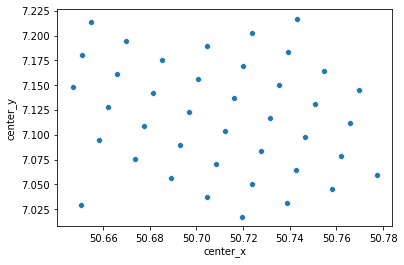

In [25]:
sns.scatterplot(hourly_availability_per_hex["center_x"], hourly_availability_per_hex["center_y"])

In [26]:
hourly_availability_per_hex.describe()

,month,day,weekday,weekend,time_basket,available_bikes,center_x,center_y
count,69200.00000,69200.000000,69200.000000,69200.000000,69200.000000,69200.000000,69200.000000,69200.000000
mean,6.82948,16.034682,2.994220,0.286127,2.000000,21.495271,50.710820,7.118481
std,3.28202,8.836337,2.007219,0.451953,1.414224,172.041491,0.036899,0.055129
min,1.00000,1.000000,0.000000,0.000000,0.000000,-1557.000000,50.646902,7.017737
25%,4.00000,8.000000,1.000000,0.000000,1.000000,0.000000,50.680515,7.074485
50%,7.00000,16.000000,3.000000,0.000000,2.000000,14.333333,50.714108,7.120063
75%,10.00000,24.000000,5.000000,1.000000,3.000000,66.500000,50.740048,7.162264
max,12.00000,31.000000,6.000000,1.000000,4.000000,641.400000,50.777343,7.216912


### Adding the average of the temperature and the distance to the next station, precipitation y/n and the mode of the land use features of the hexgaon

In [27]:
availability_data.columns

Index(['Code_18', 'datetime', 'b_number', 'trip', 'p_lat', 'p_lng', 'p_name',
       'available_bikes', 'city', 'month', 'day', 'hour', 'temperature °C',
       'relative_humidity', 'precipitaion_level (mm)', 'precipitation y/n',
       'average_wind_speed (m/s)', 'urban_fabric',
       'discontinuous_urban_fabric', 'continuous_urban_fabric',
       'industry_commercial', 'green_urban_area', 'agricultural_area',
       'forest', 'water_courses', 'distance_next_station', 'h3_hex_id'],
      dtype='object')

In [28]:
availability_data["time_basket"] = availability_data["hour"].apply(lambda x: get_timebasket(x))

In [29]:
# grouped dataframe to calculate the mean of the temperature and the distance to the next station per day and timebasket 
grouped_weather = pd.DataFrame(availability_data.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False).mean())
grouped_weather.reset_index(inplace=True)
grouped_weather = grouped_weather[['time_basket', 'h3_hex_id', 'month', 'day',"temperature °C","precipitaion_level (mm)", "distance_next_station"]]
grouped_weather

,time_basket,h3_hex_id,month,day,temperature °C,precipitaion_level (mm),distance_next_station
0,0,871fa1032ffffff,4,12,3.845455,0.000000,0.254235
1,0,871fa1032ffffff,4,14,0.000000,0.000000,0.247852
2,0,871fa1032ffffff,4,15,4.600000,0.000000,0.247852
3,0,871fa1032ffffff,4,21,16.800000,0.000000,0.657147
4,0,871fa1032ffffff,4,22,19.700000,0.000000,0.396565
...,...,...,...,...,...,...,...
46676,4,871fa1c4dffffff,12,27,2.900000,0.092982,0.161988
46677,4,871fa1c4dffffff,12,28,-0.011111,0.000000,0.148554
46678,4,871fa1c4dffffff,12,29,-0.436752,0.000000,0.148114
46679,4,871fa1c4dffffff,12,30,0.552857,0.000000,0.139345


In [30]:
# grouped dataframe to get "precipitation y/n" for the group
grouped_rain_bool = pd.DataFrame(availability_data.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False).max())
grouped_rain_bool.reset_index(inplace=True)
grouped_rain_bool = grouped_rain_bool[['time_basket', 'h3_hex_id', 'month', 'day',"precipitation y/n"]]
grouped_rain_bool

,time_basket,h3_hex_id,month,day,precipitation y/n
0,0,871fa1032ffffff,4,12,0
1,0,871fa1032ffffff,4,14,0
2,0,871fa1032ffffff,4,15,0
3,0,871fa1032ffffff,4,21,0
4,0,871fa1032ffffff,4,22,0
...,...,...,...,...,...
46676,4,871fa1c4dffffff,12,27,1
46677,4,871fa1c4dffffff,12,28,0
46678,4,871fa1c4dffffff,12,29,0
46679,4,871fa1c4dffffff,12,30,0


In [31]:
# group by hex, month, day and timebasket 
# use the value for the land features that occurs most often within one group
grouped_land_use = pd.DataFrame(availability_data.groupby(['h3_hex_id','month', 'day', 'time_basket'], as_index = False)
                                ['urban_fabric', 'discontinuous_urban_fabric', 'continuous_urban_fabric','industry_commercial', 
                                 'green_urban_area', 'agricultural_area', 'forest', 'water_courses'].agg(lambda x:x.value_counts().index[0]))
grouped_land_use.reset_index(inplace=True,drop=True)
grouped_land_use

,h3_hex_id,month,day,time_basket,urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses
0,871fa1032ffffff,3,3,2,1,1,0,0,0,0,0,0
1,871fa1032ffffff,3,21,3,1,0,1,0,0,0,0,0
2,871fa1032ffffff,3,21,4,1,1,0,0,0,0,0,0
3,871fa1032ffffff,3,22,4,1,1,1,0,0,0,0,0
4,871fa1032ffffff,3,23,2,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
46676,871fa1c4dffffff,12,31,0,1,1,0,0,0,0,0,0
46677,871fa1c4dffffff,12,31,1,1,1,0,0,0,0,0,0
46678,871fa1c4dffffff,12,31,2,1,1,0,0,0,0,0,0
46679,871fa1c4dffffff,12,31,3,1,1,0,0,0,0,0,0


In [32]:
# merge mean temperature with the demands 
df_availability = hourly_availability_per_hex.merge(grouped_weather, on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

# merge to get value for precipitation as a boolean value 
df_availability = df_availability.merge(grouped_rain_bool, on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

# merge to get the correct values for the land features
df_availability = df_availability.merge(grouped_land_use,on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

df_availability

,h3_hex_id,month,day,weekday,weekend,time_basket,available_bikes,center,center_x,center_y,...,distance_next_station,precipitation y/n,urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses
0,871fa1032ffffff,3,3,6,1,2,0.000000,"(50.65461869788869, 7.214118833734157)",50.654619,7.214119,...,0.630485,0,1,1,0,0,0,0,0,0
1,871fa1032ffffff,3,21,3,0,3,0.800000,"(50.65461869788869, 7.214118833734157)",50.654619,7.214119,...,0.195067,0,1,0,1,0,0,0,0,0
2,871fa1032ffffff,3,21,3,0,4,0.166667,"(50.65461869788869, 7.214118833734157)",50.654619,7.214119,...,0.194145,0,1,1,0,0,0,0,0,0
3,871fa1032ffffff,3,22,4,0,4,1.000000,"(50.65461869788869, 7.214118833734157)",50.654619,7.214119,...,0.311696,0,1,1,1,0,0,0,0,0
4,871fa1032ffffff,3,23,5,1,2,1.800000,"(50.65461869788869, 7.214118833734157)",50.654619,7.214119,...,0.518128,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46676,871fa1c4dffffff,12,31,1,0,0,313.333333,"(50.758136109063116, 7.0453021632135675)",50.758136,7.045302,...,0.101344,1,1,1,0,0,0,0,0,0
46677,871fa1c4dffffff,12,31,1,0,1,314.000000,"(50.758136109063116, 7.0453021632135675)",50.758136,7.045302,...,0.111355,0,1,1,0,0,0,0,0,0
46678,871fa1c4dffffff,12,31,1,0,2,314.200000,"(50.758136109063116, 7.0453021632135675)",50.758136,7.045302,...,0.115269,0,1,1,0,0,0,0,0,0
46679,871fa1c4dffffff,12,31,1,0,3,310.800000,"(50.758136109063116, 7.0453021632135675)",50.758136,7.045302,...,0.107553,0,1,1,0,0,0,0,0,0


In [33]:
df_availability["weekend"] = df_availability["weekend"].apply(lambda x : 1 if x else 0)

In [34]:
# create new feature for better prediction results 
# distances from the center of the hexagons to the CentralStation / University 
df_availability["distanceToCentralStation"] = df_availability[["center_x","center_y"]].apply(
    lambda x: vincenty([x[0], x[1]], [50.731944, 7.096944]), axis=1)
df_availability["distanceToUniversity"] = df_availability[["center_x","center_y"]].apply(
    lambda x: vincenty([x[0], x[1]], [50.72682, 7.0888]), axis=1)

In [35]:
df_availability.describe()
# --> min temperature doesn't make sense 
# this incorrect values are handled below 

,month,day,weekday,weekend,time_basket,available_bikes,center_x,center_y,temperature °C,precipitaion_level (mm),...,urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses,distanceToCentralStation,distanceToUniversity
count,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,...,46681.000000,46681.000000,46681.00000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000
mean,6.926694,15.975493,2.978492,0.280221,2.072985,31.808150,50.717386,7.119996,8.403134,0.073845,...,0.977978,0.919389,0.04128,0.030826,0.002678,0.001907,0.000407,0.000321,4.951837,5.005145
std,3.191802,8.862109,1.997752,0.449112,1.428339,208.123907,0.032227,0.050850,61.009107,0.344884,...,0.146756,0.272240,0.19894,0.172849,0.051678,0.043623,0.020171,0.017923,2.549830,2.579840
min,1.000000,1.000000,0.000000,0.000000,0.000000,-1557.000000,50.646902,7.017737,-999.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.033620,0.341213
25%,4.000000,8.000000,1.000000,0.000000,1.000000,8.500000,50.696830,7.078498,7.009091,0.000000,...,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.235797,2.699422
50%,7.000000,16.000000,3.000000,0.000000,2.000000,40.333333,50.719916,7.122848,12.400000,0.000000,...,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,4.666416,4.454742
75%,10.000000,24.000000,5.000000,1.000000,3.000000,93.000000,50.742822,7.164308,17.540000,0.000000,...,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,6.175811,6.298869
max,12.000000,31.000000,6.000000,1.000000,4.000000,641.400000,50.777343,7.216912,39.400000,14.400000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,11.939101,11.955306


In [36]:
# fill incorrect values with mean values of the corresponding month
temp_means = df_availability[df_availability["temperature °C"] >= -25].groupby(["month"]).mean()[["temperature °C"]]
for i, row in df_availability.iterrows():     
    if row["temperature °C"] < -25: # lowest temperature in Germany in 2019 was about -20° Celsius 
        df_availability.at[i, "temperature °C"] = temp_means.iloc[row["month"]]        

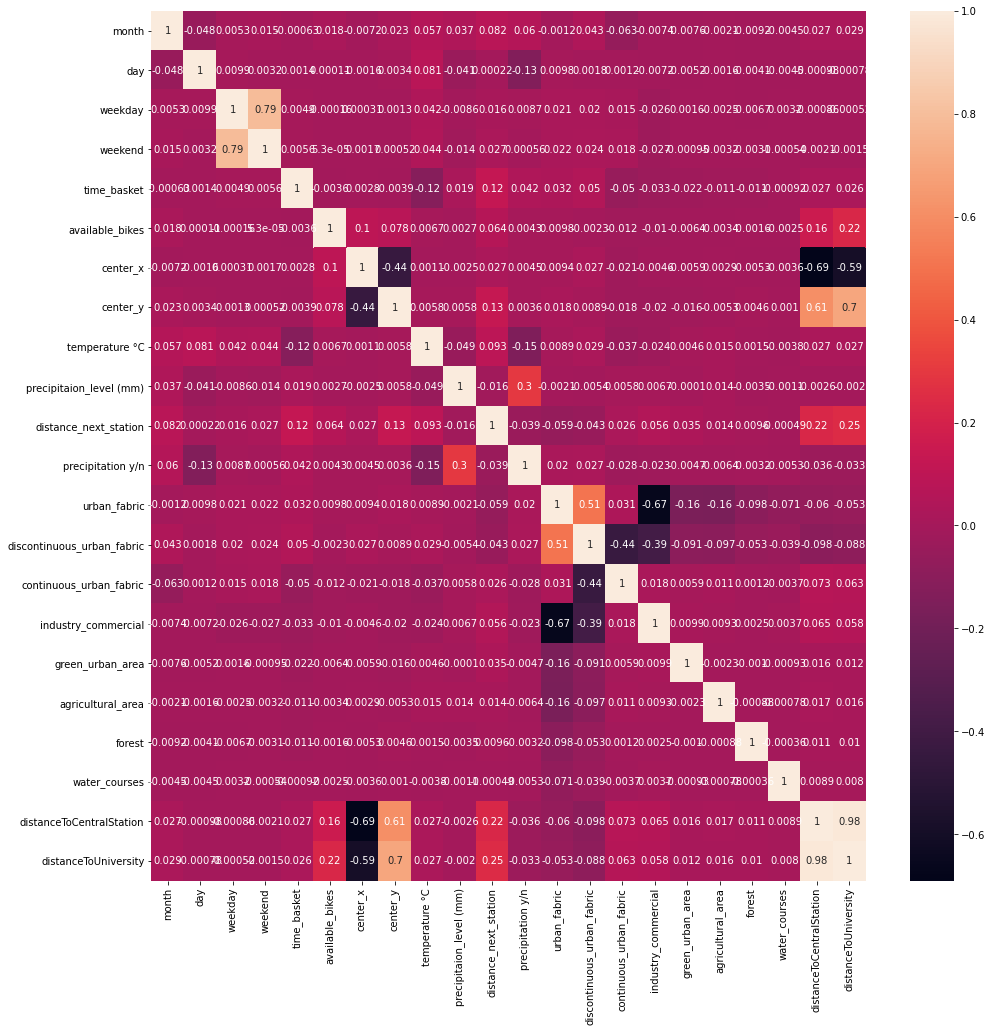

In [37]:
# get a feeling of correlations between the Availability and the other features 
plt.figure(figsize=(16, 16))
sns.heatmap(df_availability.corr(), annot=True)
plt.show()

In [38]:
df_availability.corr()[["available_bikes"]]

,available_bikes
month,0.018074
day,0.000113
weekday,-0.000158
weekend,0.000053
time_basket,-0.003633
available_bikes,1.000000
center_x,0.101878
center_y,0.077800
temperature °C,0.006711
precipitaion_level (mm),0.002707


In [39]:
df_availability.describe()

,month,day,weekday,weekend,time_basket,available_bikes,center_x,center_y,temperature °C,precipitaion_level (mm),...,urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses,distanceToCentralStation,distanceToUniversity
count,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,...,46681.000000,46681.000000,46681.00000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000,46681.000000
mean,6.926694,15.975493,2.978492,0.280221,2.072985,31.808150,50.717386,7.119996,12.718028,0.073845,...,0.977978,0.919389,0.04128,0.030826,0.002678,0.001907,0.000407,0.000321,4.951837,5.005145
std,3.191802,8.862109,1.997752,0.449112,1.428339,208.123907,0.032227,0.050850,7.326234,0.344884,...,0.146756,0.272240,0.19894,0.172849,0.051678,0.043623,0.020171,0.017923,2.549830,2.579840
min,1.000000,1.000000,0.000000,0.000000,0.000000,-1557.000000,50.646902,7.017737,-8.700000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.033620,0.341213
25%,4.000000,8.000000,1.000000,0.000000,1.000000,8.500000,50.696830,7.078498,7.086364,0.000000,...,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.235797,2.699422
50%,7.000000,16.000000,3.000000,0.000000,2.000000,40.333333,50.719916,7.122848,12.400000,0.000000,...,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,4.666416,4.454742
75%,10.000000,24.000000,5.000000,1.000000,3.000000,93.000000,50.742822,7.164308,17.540000,0.000000,...,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,6.175811,6.298869
max,12.000000,31.000000,6.000000,1.000000,4.000000,641.400000,50.777343,7.216912,39.400000,14.400000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,11.939101,11.955306


In [40]:
df_availability.to_csv('Data/availability_SVR.csv')

Creating dummy variables:

In [41]:
df_availability_dummies = pd.get_dummies(df_availability, columns=['time_basket', 'month', 'weekday'])

In [42]:
df_availability_dummies.columns

Index(['h3_hex_id', 'day', 'weekend', 'available_bikes', 'center', 'center_x',
       'center_y', 'temperature °C', 'precipitaion_level (mm)',
       'distance_next_station', 'precipitation y/n', 'urban_fabric',
       'discontinuous_urban_fabric', 'continuous_urban_fabric',
       'industry_commercial', 'green_urban_area', 'agricultural_area',
       'forest', 'water_courses', 'distanceToCentralStation',
       'distanceToUniversity', 'time_basket_0', 'time_basket_1',
       'time_basket_2', 'time_basket_3', 'time_basket_4', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

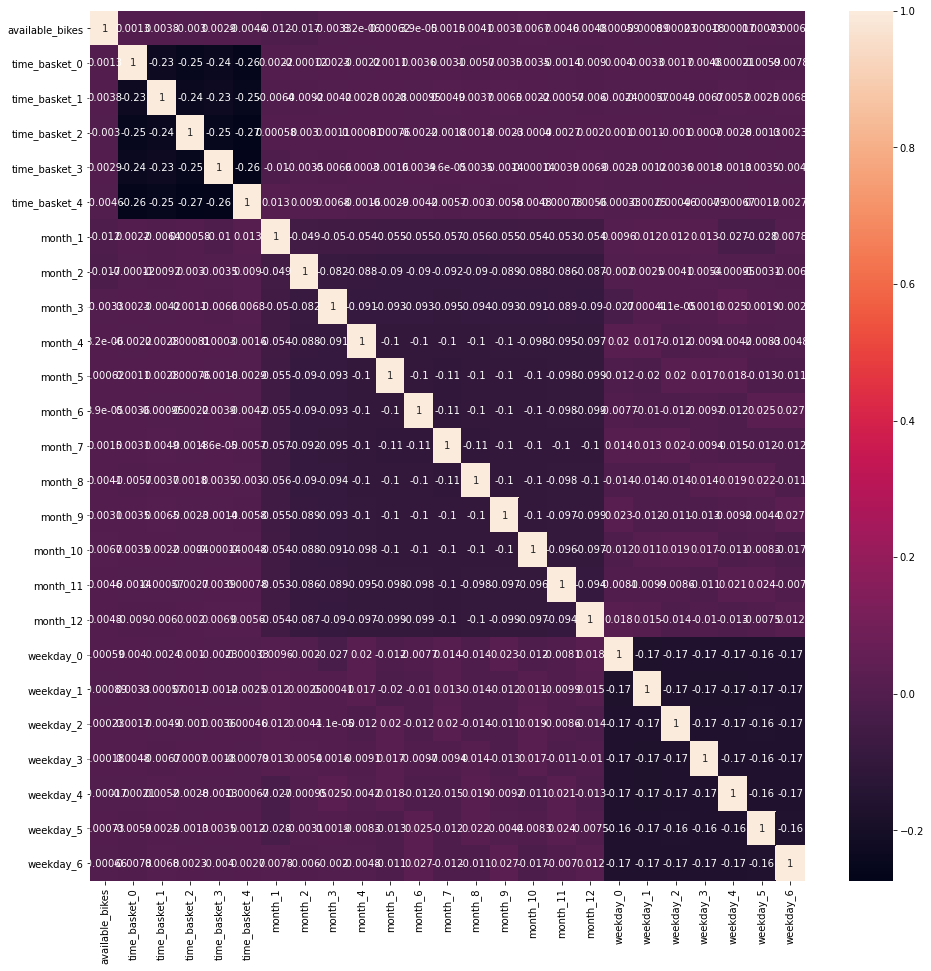

In [43]:
# get a feeling of correlations between the Availability and the other features 
plt.figure(figsize=(16, 16))
sns.heatmap(df_availability_dummies[['available_bikes', 'time_basket_0', 'time_basket_1',
                                     'time_basket_2', 'time_basket_3', 'time_basket_4', 'month_1', 'month_2',
                                     'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
                                     'month_9', 'month_10', 'month_11', 'month_12', 'weekday_0', 'weekday_1', 
                                     'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']].corr(), annot=True)
plt.show()

In [44]:
df_availability_dummies.corr()[["available_bikes"]]

,available_bikes
day,0.000113
weekend,0.000053
available_bikes,1.000000
center_x,0.101878
center_y,0.077800
temperature °C,0.006711
precipitaion_level (mm),0.002707
distance_next_station,0.063928
precipitation y/n,0.004282
urban_fabric,0.009782


In [45]:
df_availability_dummies.to_csv('Data/availability_dummies_SVR.csv')

## SVRs

In [46]:
df_availability = pd.read_csv('Data/availability_SVR.csv')

In [48]:
df_availability_dummies =  pd.read_csv('Data/availability_dummies_SVR.csv')

In [49]:
df_availability.columns

Index(['Unnamed: 0', 'h3_hex_id', 'month', 'day', 'weekday', 'weekend',
       'time_basket', 'available_bikes', 'center', 'center_x', 'center_y',
       'temperature °C', 'precipitaion_level (mm)', 'distance_next_station',
       'precipitation y/n', 'urban_fabric', 'discontinuous_urban_fabric',
       'continuous_urban_fabric', 'industry_commercial', 'green_urban_area',
       'agricultural_area', 'forest', 'water_courses',
       'distanceToCentralStation', 'distanceToUniversity'],
      dtype='object')

In [50]:
df_availability

,Unnamed: 0,h3_hex_id,month,day,weekday,weekend,time_basket,available_bikes,center,center_x,...,urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses,distanceToCentralStation,distanceToUniversity
0,0,871fa1032ffffff,3,3,6,1,2,0.000000,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,1,0,0,0,0,0,0,11.939101,11.955306
1,1,871fa1032ffffff,3,21,3,0,3,0.800000,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,0,1,0,0,0,0,0,11.939101,11.955306
2,2,871fa1032ffffff,3,21,3,0,4,0.166667,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,1,0,0,0,0,0,0,11.939101,11.955306
3,3,871fa1032ffffff,3,22,4,0,4,1.000000,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,1,1,0,0,0,0,0,11.939101,11.955306
4,4,871fa1032ffffff,3,23,5,1,2,1.800000,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,1,0,0,0,0,0,0,11.939101,11.955306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46676,46676,871fa1c4dffffff,12,31,1,0,0,313.333333,"(50.758136109063116, 7.0453021632135675)",50.758136,...,1,1,0,0,0,0,0,0,4.666416,4.643606
46677,46677,871fa1c4dffffff,12,31,1,0,1,314.000000,"(50.758136109063116, 7.0453021632135675)",50.758136,...,1,1,0,0,0,0,0,0,4.666416,4.643606
46678,46678,871fa1c4dffffff,12,31,1,0,2,314.200000,"(50.758136109063116, 7.0453021632135675)",50.758136,...,1,1,0,0,0,0,0,0,4.666416,4.643606
46679,46679,871fa1c4dffffff,12,31,1,0,3,310.800000,"(50.758136109063116, 7.0453021632135675)",50.758136,...,1,1,0,0,0,0,0,0,4.666416,4.643606


### First basic Support Vector Machines:

In [51]:
def runSVR_basic(df, featureList): 
    X = df[featureList]
    y = df[["available_bikes"]]
    X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)
    
    scaler = StandardScaler()

    svr = SVR()
    svr.fit(scaler.fit_transform(X_train), y_train)
    y_pred = svr.predict(scaler.fit_transform(X_train))

    r2 = r2_score(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)
    
    print('ON TRAINING DATA', '\n',
          'R2: ', "{:.2f}".format(r2), '\n',
          'MAE: ', "{:.2f}".format(mae),'\n',
          'MSE: ',  "{:.2f}".format(mse),'\n',
          'RMSE: ', "{:.2f}".format(rmse))    
    
    y_pred = svr.predict(scaler.fit_transform(X_test))

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print('ON TEST DATA', '\n',
          'R2: ',  "{:.2f}".format(r2), '\n',
          'MAE: ',  "{:.2f}".format(mae),'\n',
          'MSE: ',  "{:.2f}".format(mse),'\n',
          'RMSE: ', "{:.2f}".format(rmse))    

In [54]:
features = ["time_basket", "month", "center_x", "center_y", "weekend", "temperature °C", "precipitaion_level (mm)", 
            "distance_next_station", "distanceToCentralStation", "distanceToUniversity", "urban_fabric", "industry_commercial", 
            "green_urban_area"]

runSVR_basic(df_availability, features)

ON TRAINING DATA 
 R2:  0.19 
 MAE:  68.08 
 MSE:  34960.18 
 RMSE:  186.98
ON TEST DATA 
 R2:  0.18 
 MAE:  67.93 
 MSE:  35587.98 
 RMSE:  188.65


In [56]:
features =["time_basket", "month", "center_x", "center_y", "weekend", "temperature °C", "precipitaion_level (mm)", 
           "distance_next_station", "distanceToCentralStation", "distanceToUniversity", "discontinuous_urban_fabric", 
           "continuous_urban_fabric", "industry_commercial", "green_urban_area"]

runSVR_basic(df_availability, features)

ON TRAINING DATA 
 R2:  0.18 
 MAE:  68.72 
 MSE:  35285.95 
 RMSE:  187.85
ON TEST DATA 
 R2:  0.18 
 MAE:  68.62 
 MSE:  35924.74 
 RMSE:  189.54


In [57]:
features =["time_basket", "month", "center_x", "center_y", "weekday", "temperature °C", "precipitaion_level (mm)", 
           "distance_next_station", "distanceToCentralStation", "distanceToUniversity", "urban_fabric", 
           "industry_commercial", "green_urban_area"]

runSVR_basic(df_availability, features)

ON TRAINING DATA 
 R2:  0.19 
 MAE:  68.13 
 MSE:  34944.34 
 RMSE:  186.93
ON TEST DATA 
 R2:  0.18 
 MAE:  67.97 
 MSE:  35566.24 
 RMSE:  188.59


In [61]:
features =['time_basket', 'month', 'center_x', 'center_y', 'weekend', 'distance_next_station', 'distanceToCentralStation', 
           'distanceToUniversity']

runSVR_basic(df_availability, features)

ON TRAINING DATA 
 R2:  0.29 
 MAE:  62.75 
 MSE:  30798.83 
 RMSE:  175.50
ON TEST DATA 
 R2:  0.29 
 MAE:  62.25 
 MSE:  31188.47 
 RMSE:  176.60


#### With dummy variables

In [58]:
features =['center_x', 'center_y', 'distance_next_station', 'distanceToCentralStation', 'distanceToUniversity', 'time_basket_0',
           'time_basket_1', 'time_basket_2', 'time_basket_3', 'time_basket_4', 'month_1', 'month_2',  'month_3', 'month_4', 
           'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'weekend']

runSVR_basic(df_availability_dummies, features)

ON TRAINING DATA 
 R2:  0.07 
 MAE:  77.07 
 MSE:  40018.58 
 RMSE:  200.05
ON TEST DATA 
 R2:  0.07 
 MAE:  76.98 
 MSE:  40757.25 
 RMSE:  201.88


In [59]:
features =['center_x', 'center_y', 'temperature °C', 'distance_next_station', 'urban_fabric', 'industry_commercial', 
           'green_urban_area', 'agricultural_area', 'distanceToCentralStation', 'distanceToUniversity', 'time_basket_0',
           'time_basket_1', 'time_basket_2', 'time_basket_3', 'time_basket_4', 'month_1', 'month_2',  'month_3', 'month_4', 
           'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'weekend', 'precipitation y/n']

runSVR_basic(df_availability_dummies, features)

ON TRAINING DATA 
 R2:  0.06 
 MAE:  78.10 
 MSE:  40518.00 
 RMSE:  201.29
ON TEST DATA 
 R2:  0.05 
 MAE:  78.03 
 MSE:  41269.80 
 RMSE:  203.15


In [60]:
features =['center_x', 'center_y', 'temperature °C', 'distance_next_station', 'urban_fabric', 'industry_commercial',
           'green_urban_area', 'agricultural_area', 'distanceToCentralStation', 'distanceToUniversity', 'time_basket_0',
           'time_basket_1', 'time_basket_2', 'time_basket_3', 'time_basket_4', 'month_1', 'month_2','month_3', 'month_4', 
           'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'weekday_0', 
           'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'precipitaion_level (mm)']

runSVR_basic(df_availability_dummies, features)

ON TRAINING DATA 
 R2:  0.05 
 MAE:  80.07 
 MSE:  41085.00 
 RMSE:  202.69
ON TEST DATA 
 R2:  0.04 
 MAE:  80.09 
 MSE:  41839.45 
 RMSE:  204.55


In [63]:
features =['time_basket_0', 'time_basket_1', 'time_basket_2', 'time_basket_3', 'time_basket_4', 'month_1', 'month_2','month_3', 
           'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'center_x', 'center_y',
           'weekend', 'distance_next_station', 'distanceToCentralStation', 'distanceToUniversity']

runSVR_basic(df_availability_dummies, features)

ON TRAINING DATA 
 R2:  0.07 
 MAE:  77.07 
 MSE:  40018.58 
 RMSE:  200.05
ON TEST DATA 
 R2:  0.07 
 MAE:  76.98 
 MSE:  40757.25 
 RMSE:  201.88


Decision for:

In [64]:
features =['time_basket', 'month', 'center_x', 'center_y', 'weekend', 'distance_next_station', 'distanceToCentralStation', 
           'distanceToUniversity']

Metrics/ results on Training Data are close to the results on the Test Data --> Model is not overfitted

### More advanced Support Vector Machines:

In [65]:
def runSVR(featureList, kernel, C, epsilon, gamma): 
    X = df_availability[featureList]
    y = df_availability[["available_bikes"]]
    X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)
    
    scaler = StandardScaler()

    svr = SVR(kernel,C=C,epsilon=epsilon,gamma=gamma)
    svr.fit(scaler.fit_transform(X_train), y_train)
    y_pred = svr.predict(scaler.fit_transform(X_train))

    r2 = r2_score(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)
    
    print('ON TRAINING DATA', '\n',
          'R2: ', "{:.2f}".format(r2), '\n',
          'MAE: ', "{:.2f}".format(mae),'\n',
          'MSE: ',  "{:.2f}".format(mse),'\n',
          'RMSE: ', "{:.2f}".format(rmse))    
    
    y_pred = svr.predict(scaler.fit_transform(X_test))

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print('ON TEST DATA', '\n',
          'R2: ',  "{:.2f}".format(r2), '\n',
          'MAE: ',  "{:.2f}".format(mae),'\n',
          'MSE: ',  "{:.2f}".format(mse),'\n',
          'RMSE: ', "{:.2f}".format(rmse))    

## Grid Search

In [350]:
# first grid search
X = df_availability[features]
y = df_availability[["available_bikes"]]

gsc = GridSearchCV(
        estimator=SVR("rbf"),
        param_grid={            
            'C': [0.1, 1, 10],
            'epsilon': [0.1, 0.5, 1, 5, 10],
            'gamma': [0.1, 0.5, 1, 5, 10]
        },
        cv=3, scoring="r2", verbose=0, n_jobs=-1)
grid_result = gsc.fit(X, y)
best_params = grid_result.best_params_
best_params

{'C': 10, 'epsilon': 1, 'gamma': 0.1}

In [ ]:
# after first grid search
# set the features that are found by grid search
runSVR(featureList=features, kernel='rbf', C=10,epsilon=1,gamma=0.1)

--> Results get much better after hyperparameter optimization 

In [8]:
# second grid search
# scoring: neg_mean_absolute_error

X = df_availability[features]
y = df_availability[["available_bikes"]]

# second try 
gsc = GridSearchCV(
        estimator=SVR("rbf"),
        param_grid={            
            'C': [1, 10,15],
            'epsilon': [5, 10,15],
            'gamma': [0.01,0.05,0.1]
        },
        cv=3, scoring="neg_mean_absolute_error", verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y)
best_params = grid_result.best_params_
best_params

{'C': 15, 'epsilon': 15, 'gamma': 0.05}

In [70]:
# after second grid search
# scoring on MAE

runSVR(features,'rbf', C=15,epsilon=15,gamma=0.05)

ON TRAINING DATA 
 R2:  0.48 
 MAE:  57.10 
 MSE:  22270.98 
 RMSE:  149.23
ON TEST DATA 
 R2:  0.49 
 MAE:  56.18 
 MSE:  22058.26 
 RMSE:  148.52


In [13]:
# second grid search
# scoring: r2

X = df_availability[features]
y = df_availability[["available_bikes"]]

# second try 
gsc = GridSearchCV(
        estimator=SVR("rbf"),
        param_grid={            
            'C': [1, 10,15],
            'epsilon': [5, 10,15],
            'gamma': [0.01,0.05,0.1]
        },
        cv=3, scoring="r2", verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y)
best_params = grid_result.best_params_
best_params

{'C': 15, 'epsilon': 5, 'gamma': 0.05}

In [72]:
# after second grid search
# scoring on r2

runSVR(features, 'rbf', C=15,epsilon=5,gamma=0.05)

ON TRAINING DATA 
 R2:  0.48 
 MAE:  56.63 
 MSE:  22339.85 
 RMSE:  149.47
ON TEST DATA 
 R2:  0.49 
 MAE:  55.69 
 MSE:  22115.42 
 RMSE:  148.71


--> all metrics get worse

In [ ]:
#third try (Sigmoid)

X = df_availability[features]
y = df_availability[["available_bikes"]]

gsc = GridSearchCV(
        estimator=SVR("sigmoid"),
        param_grid={            
            'C': [1, 10,15],
            'epsilon': [1, 5, 10],
            'gamma': [0.01,0.05,0.1]
        },
        cv=3, scoring="neg_mean_absolute_error", verbose=0, n_jobs=-1)
grid_result = gsc.fit(X, y)
best_params = grid_result.best_params_
best_params

In [ ]:
# after third grid search

runSVR(features,kernel="sigmoid",C=1, epsilon=5, gamma=0.01)

--> Sigmoid as kernel leads to much worse results 

## Varying Hexagon resolution and time baskets 

First of all, we create a function (prepareAvailabilityData) that does all the necessary steps for the preparation of the availability dataframe for different hexagon resolutions and time baskets. 

In [73]:
# read in transformed availability data
availability_data = pd.read_csv("Data/bonn_availability.csv", index_col=0)

In [76]:
def prepareAvailabilityData(hex_resolution=8, periodLength=6, df=availability_data): 
    """
    periodLength = 24h / 6h / 2h / 1h
    hex_resolution = 5 / 6 / 7 / 8 / 9 
    """
    # creating hexagons with size 7    
    availability_data = createHexagons(df, hex_resolution)
    
    trips = ['start', 'end']
    availability_data_start_end = df[df.trip.isin(trips)]
    
    availability_data2=availability_data_start_end.sort_values(['b_number', 'datetime'])
    
    #After checking the amount of end and start trips, we see that there is no even amount of start and end trips 
    #so let's check sequences and eliminate those that do not form a pair
    #it eliminates those where the b_number is the same and the trip type is the same of two following rows
    #and those where the bike number is not the same but the trip type is the same 
    m1 = (availability_data2['b_number'] == availability_data2['b_number'].shift(-1))
    m2 = (availability_data2['trip'] == availability_data2['trip'].shift(-1))
    m3 = (availability_data2['b_number'] != availability_data2['b_number'].shift(-1))
    m4 = (availability_data2['trip'] == availability_data2['trip'].shift(-1))
    availability = availability_data2[~((m1&m2)|(m3&m4))]
    
    # sort dataframe so that we can locate the first occurrence of every bike
    df_firstocc = df.sort_values(['month', 'day', 'hour'])
    
    # first occurence of every bike in 2019
    first_occ_ofallbikes = df_firstocc.loc[df_firstocc.trip =='first'].groupby('b_number').head(1)
    
    frames = [availability, first_occ_ofallbikes]
    
    availability_data_start_end_firstocc= pd.concat(frames)
    
    availability_data_start_end_firstocc2 = availability_data_start_end_firstocc
    
    availability_data_start_end_firstocc2['available_bikes']= availability_data_start_end_firstocc2.apply(lambda x: 1 if ((x.trip == 'end')|(x.trip == 'first')) else (-1), axis=1)
    
    grouped_2 = availability_data_start_end_firstocc2[['h3_hex_id','month', 'day', 'hour', 'available_bikes']].groupby(['h3_hex_id','month', 'day', 'hour'], as_index = False).sum()
    
    grouped_2 = grouped_2.sort_values(['month', 'day', 'hour']).groupby('h3_hex_id')
    
    all_groups = []
    for group in grouped_2.groups:
    
        group = grouped_2.get_group(group)
        group = group.reset_index()
    
        group['available_bikes']= np.cumsum(group['available_bikes'])  
    
        all_groups.append(group)

    cumulativesum_df = pd.concat(all_groups)
    
    #saving the unique h3_hex_ids
    h3_hex_ids = cumulativesum_df['h3_hex_id'].unique()
    
    #create new dataframe with the same columns
    all_availability = pd.DataFrame(columns=["h3_hex_id", "datetime", "month","day","hour", "available_bikes"])
    
    #add the unique h3_hex_ids
    all_availability['h3_hex_id'] = h3_hex_ids
    
    #create a time range for the new dataframe starting from the 20/01/2019 as our provided data starts at that time
    datelist = pd.date_range('2019-01-20 00:00:00', '2019-12-31 23:59:00', freq='H').tolist()

    for i in range(0, len(h3_hex_ids)):
        all_availability['datetime'][i] = datelist
    
    s = all_availability.apply(lambda x: pd.Series(x['datetime']),axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'datetime'

    all_availability = all_availability.drop('datetime', axis=1).join(s)
    
    all_availability["datetime"] = pd.to_datetime(all_availability["datetime"])
    all_availability["day"] = all_availability["datetime"].apply(lambda x: x.day)
    all_availability["month"] = all_availability["datetime"].apply(lambda x: x.month)
    all_availability["hour"] = all_availability["datetime"].apply(lambda x: x.hour)
    
    #Merge the grouped original dataframe with the new dataframe
    availability_per_hex = pd.merge(cumulativesum_df, all_availability, left_on=['h3_hex_id', 'month', 'day', 'hour'], right_on=['h3_hex_id', 'month', 'day', 'hour'], how="outer")
    availability_per_hex = availability_per_hex.drop('available_bikes_y', axis=1)
    availability_per_hex = availability_per_hex.rename(columns= {'available_bikes_x': 'available_bikes'})
    
    availability_per_hex_groups = availability_per_hex.sort_values(['h3_hex_id','month', 'day', 'hour']).groupby('h3_hex_id')
    
    all_groups = []
    #split by groups   
    for group in availability_per_hex_groups.groups:
        group = availability_per_hex_groups.get_group(group)
        group = group.reset_index()
               
        #save the dataframe for one hexagon in the list all groups  
        all_groups.append(group)

    availability_per_hex = pd.concat(all_groups)
    
    availability_per_hex = availability_per_hex.drop(['level_0', 'index'], axis=1)
    
    # applying a forward fill per group to add the missing hourly available bikes per hexagon
    availability_per_hour = availability_per_hex.groupby(['h3_hex_id'], as_index=False).apply(lambda group: group.ffill())
    
    # filling the remaining NaN values with 0
    availability_per_hour = availability_per_hour.fillna(0)
    
    # adding column weekday
    availability_per_hour["weekday"] = availability_per_hour["datetime"].dt.dayofweek
    
    # adding new boolean column "weekend"    
    availability_per_hour["weekend"] = availability_per_hour["weekday"].apply(lambda x: isWeekend(x))
    
    # adding the coordinates of the center per each hexagon
    availability_per_hour["center"] = availability_per_hour["h3_hex_id"].apply(lambda x: centroid(x))
    availability_per_hour["center_x"] = availability_per_hour["center"].apply(lambda x: x[0])
    availability_per_hour["center_y"]  = availability_per_hour["center"].apply(lambda x: x[1])
    
    # adding the time basket as defined by periodLength
    availability_per_hour['time_basket'] = availability_per_hour['hour'].apply(lambda x: x//periodLength+1)
    
    # calculating the mean of the availabe bikes per hexagon, month, day and time basket
    availability_per_hour = availability_per_hour.groupby(['h3_hex_id', 'center', 'center_x', 'center_y', 'month', 'day', 'weekday', 'weekend', 'time_basket' ], as_index=False).mean()
    availability_per_hour.drop('hour', axis=1, inplace=True)

    ### Adding the average of the distance to the next station of the hexgaon

    # grouped dataframe to calculate the mean of the distance to the next station per day and timebasket 
    availability_data['time_basket'] = availability_data['hour'].apply(lambda x: x//periodLength+1)
    grouped_distance_station = pd.DataFrame(availability_data.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False).mean())
    grouped_distance_station.reset_index(inplace=True)
    grouped_distance_station = grouped_distance_station[['time_basket', 'h3_hex_id', 'month', 'day', "distance_next_station"]]

    # merge mean temperature with the availabilities 
    df_availability = availability_per_hour.merge(grouped_distance_station, on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

    # final dataframe to predict the availability per hexagon, ... 
    # adding new boolean column "weekend"    
    df_availability["weekend"] = df_availability["weekend"].apply(lambda x : 1 if x else 0)     

    # create new feature for better prediction results 
    # distances from the center of the hexagons to the CentralStation / University 
    df_availability["distanceToCentralStation"] = df_availability[["center_x","center_y"]].apply(
        lambda x: vincenty([x[0], x[1]], [50.731944, 7.096944]), axis=1)
    df_availability["distanceToUniversity"] = df_availability[["center_x","center_y"]].apply(
        lambda x: vincenty([x[0], x[1]], [50.72682, 7.0888]), axis=1)        
    
    # drop duplicate rows which have been created by mistake
    df_availability = df_availability.drop_duplicates()
    
    return df_availability
    

## SVR with ... 
* Hexagon resolution = 5 

In [78]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=5,periodLength=1,df=availability_data)

runSVR(features, kernel='rbf',C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.96 
 MAE:  21.14 
 MSE:  1146.91 
 RMSE:  33.87
ON TEST DATA 
 R2:  0.96 
 MAE:  21.76 
 MSE:  1278.80 
 RMSE:  35.76


In [81]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=5,periodLength=2,df=availability_data)

runSVR(features, kernel='rbf', C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.96 
 MAE:  21.39 
 MSE:  1183.34 
 RMSE:  34.40
ON TEST DATA 
 R2:  0.97 
 MAE:  20.80 
 MSE:  1078.56 
 RMSE:  32.84


In [82]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=5,periodLength=6,df=availability_data)

runSVR(features, kernel='rbf', C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.96 
 MAE:  21.38 
 MSE:  1241.88 
 RMSE:  35.24
ON TEST DATA 
 R2:  0.97 
 MAE:  20.25 
 MSE:  1068.03 
 RMSE:  32.68


In [83]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=5,periodLength=24,df=availability_data)

runSVR(features, kernel='rbf', C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.96 
 MAE:  24.66 
 MSE:  1473.51 
 RMSE:  38.39
ON TEST DATA 
 R2:  0.96 
 MAE:  24.11 
 MSE:  1341.64 
 RMSE:  36.63


## SVR with... 
* Hexagon resolution = 6 

In [86]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=6,periodLength=1,df=availability_data)

runSVR(features, kernel='rbf', C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.90 
 MAE:  33.69 
 MSE:  4964.77 
 RMSE:  70.46
ON TEST DATA 
 R2:  0.90 
 MAE:  34.27 
 MSE:  5062.42 
 RMSE:  71.15


In [87]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=6,periodLength=2,df=availability_data)

runSVR(features, kernel='rbf', C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.82 
 MAE:  45.93 
 MSE:  8614.88 
 RMSE:  92.82
ON TEST DATA 
 R2:  0.82 
 MAE:  45.79 
 MSE:  8509.95 
 RMSE:  92.25


In [88]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=6,periodLength=6,df=availability_data)

runSVR(features, kernel='rbf', C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.60 
 MAE:  67.06 
 MSE:  17995.51 
 RMSE:  134.15
ON TEST DATA 
 R2:  0.56 
 MAE:  73.41 
 MSE:  21009.01 
 RMSE:  144.94


In [89]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=6,periodLength=24,df=availability_data)

runSVR(features,kernel='rbf',C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.34 
 MAE:  93.42 
 MSE:  29218.22 
 RMSE:  170.93
ON TEST DATA 
 R2:  0.38 
 MAE:  98.73 
 MSE:  29771.51 
 RMSE:  172.54


In [91]:
df_availability

,h3_hex_id,center,center_x,center_y,month,day,weekday,weekend,time_basket,available_bikes,distance_next_station,distanceToCentralStation,distanceToUniversity
0,861fa1037ffffff,"(50.673831482252105, 7.227958646427965)",50.673831,7.227959,1,20,6,1,1,10.250000,0.123589,11.289631,11.463093
1,861fa1037ffffff,"(50.673831482252105, 7.227958646427965)",50.673831,7.227959,1,21,0,0,1,10.500000,0.124067,11.289631,11.463093
2,861fa1037ffffff,"(50.673831482252105, 7.227958646427965)",50.673831,7.227959,1,22,1,0,1,9.375000,0.130034,11.289631,11.463093
3,861fa1037ffffff,"(50.673831482252105, 7.227958646427965)",50.673831,7.227959,1,23,2,0,1,8.333333,0.131288,11.289631,11.463093
4,861fa1037ffffff,"(50.673831482252105, 7.227958646427965)",50.673831,7.227959,1,24,3,0,1,9.166667,0.139751,11.289631,11.463093
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3084,861fa1c4fffffff,"(50.73891623270483, 7.031519534543524)",50.738916,7.031520,12,27,4,0,1,657.666667,0.151624,4.683386,4.262000
3085,861fa1c4fffffff,"(50.73891623270483, 7.031519534543524)",50.738916,7.031520,12,28,5,1,1,650.750000,0.169786,4.683386,4.262000
3086,861fa1c4fffffff,"(50.73891623270483, 7.031519534543524)",50.738916,7.031520,12,29,6,1,1,651.541667,0.170534,4.683386,4.262000
3087,861fa1c4fffffff,"(50.73891623270483, 7.031519534543524)",50.738916,7.031520,12,30,0,0,1,655.291667,0.154170,4.683386,4.262000


## SVR with... 
* Hexagon resolution = 7

In [92]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=7,periodLength=1,df=availability_data)

runSVR(features,kernel='rbf',C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.78 
 MAE:  46.51 
 MSE:  12443.27 
 RMSE:  111.55
ON TEST DATA 
 R2:  0.78 
 MAE:  46.75 
 MSE:  12618.79 
 RMSE:  112.33


In [93]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=7,periodLength=2,df=availability_data)

runSVR(features,kernel='rbf',C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.68 
 MAE:  48.59 
 MSE:  15764.89 
 RMSE:  125.56
ON TEST DATA 
 R2:  0.68 
 MAE:  47.88 
 MSE:  14719.46 
 RMSE:  121.32


In [94]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=7,periodLength=6,df=availability_data)

runSVR(features,kernel='rbf',C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.53 
 MAE:  50.41 
 MSE:  19550.21 
 RMSE:  139.82
ON TEST DATA 
 R2:  0.53 
 MAE:  49.21 
 MSE:  18843.10 
 RMSE:  137.27


In [95]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=7,periodLength=24,df=availability_data)

runSVR(features,kernel='rbf',C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.40 
 MAE:  53.83 
 MSE:  22816.07 
 RMSE:  151.05
ON TEST DATA 
 R2:  0.37 
 MAE:  54.29 
 MSE:  24829.88 
 RMSE:  157.58


## SVR with...
* Hexagon resolution = 8

In [96]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=8,periodLength=1,df=availability_data)

runSVR(features,kernel='rbf',C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.22 
 MAE:  34.53 
 MSE:  6441.80 
 RMSE:  80.26
ON TEST DATA 
 R2:  0.22 
 MAE:  34.72 
 MSE:  6428.19 
 RMSE:  80.18


In [97]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=8,periodLength=2,df=availability_data)

runSVR(features,kernel='rbf',C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.19 
 MAE:  30.61 
 MSE:  5456.88 
 RMSE:  73.87
ON TEST DATA 
 R2:  0.18 
 MAE:  30.80 
 MSE:  5591.13 
 RMSE:  74.77


In [98]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=8,periodLength=6,df=availability_data)

runSVR(features,kernel='rbf',C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.13 
 MAE:  26.31 
 MSE:  4587.53 
 RMSE:  67.73
ON TEST DATA 
 R2:  0.14 
 MAE:  26.14 
 MSE:  4499.09 
 RMSE:  67.08


In [99]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=8,periodLength=24,df=availability_data)

runSVR(features,kernel='rbf',C=10,epsilon=1,gamma=0.1)

ON TRAINING DATA 
 R2:  0.09 
 MAE:  24.41 
 MSE:  4220.05 
 RMSE:  64.96
ON TEST DATA 
 R2:  0.09 
 MAE:  24.32 
 MSE:  4401.60 
 RMSE:  66.34


## SVR with...
* Hexagon resolution = 9

In [ ]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=9,periodLength=1,df=availability_data)

runSVR(features,kernel='rbf',C=10,epsilon=1,gamma=0.1)

In [ ]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=9,periodLength=2,df=availability_data)

runSVR(features,kernel='rbf',C=10,epsilon=1,gamma=0.1)

In [ ]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=9,periodLength=6,df=availability_data)

runSVR(features,kernel='rbf',C=10,epsilon=1,gamma=0.1)

In [ ]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=9,periodLength=24,df=availability_data)

runSVR(features,kernel='rbf',C=10,epsilon=1,gamma=0.1)